In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency, metrics

import helper

np.random.seed(247)
tf.set_random_seed(247)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load dataset

In [2]:
# dataset path# save path
results_path = utils.make_directory('../results', 'synthetic')
params_path = utils.make_directory(results_path, 'model_params')

# load dataset
data_path = '../data/synthetic_dataset.h5'
train, valid, test = helper.load_synthetic_dataset(data_path)

test_model = helper.load_synthetic_TF_models(data_path, dataset='test')
    
    
# get data shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = [None, train['targets'].shape[1]]

loading training data
loading cross-validation data
loading test data


# Load model

In [3]:
tf.reset_default_graph()

model_name = 'cnn_2'
# model_name = 'cnn_25_4'

# load model parameters
genome_model = helper.import_model(model_name)
model_layers, optimization = genome_model.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)
nnmodel.inspect_layers()

# create neural trainer
file_path = os.path.join(params_path, model_name)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)

# get the model predictions (activations) and the logits (threshold)
activations = nntrainer.get_activations(sess, test, layer='output')
threshold = nntrainer.get_activations(sess, test, layer=nnmodel.network.keys()[-2])

sess.close()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 200, 1, 4)
layer2: conv1d_0
(?, 200, 1, 30)
layer3: conv1d_0_batch
(?, 200, 1, 30)
layer4: conv1d_0_active
(?, 200, 1, 30)
layer5: conv1d_0_maxpool
(?, 100, 1, 30)
layer6: conv1d_0_dropout
(?, 100, 1, 30)
layer7: conv1d_1
(?, 100, 1, 128)
layer8: conv1d_1_batch
(?, 100, 1, 128)
layer9: conv1d_1_active
(?, 100, 1, 128)
layer10: conv1d_1_maxpool
(?, 2, 1, 128)
layer11: conv1d_1_dropout
(?, 2, 1, 128)
layer12: dense_0
(?, 512)
layer13: dense_0_batch
(?, 512)
layer14: dense_0_active
(?, 512)
layer15: dense_0_dropout
(?, 512)
layer16: dense_1
(?, 12)
layer17: dense_1_bias
(?, 12)
layer18: output
(?, 12)
----------------------------------------------------------------------------
loading model from:  ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../result

# Plot top saliency maps for each class

In [31]:
save_path = utils.make_directory(results_path, 'saliency_backprop')

# get number of class labels for each sequence
class_sum = np.sum(test['targets'], axis=1)

num_plots = 5

# loop through different transcription factors
for class_index in range(12)[::-1]:
    
    # get indices of a sequence that has a positive label and has a single class label
    right_indices = np.where((test['targets'][:,class_index]==1) & 
                                   (class_sum == 1)
                                  )[0]

    # sort by most confident predictions
    right_indices = right_indices[np.argsort(activations[right_indices, class_index])[::-1]][:num_plots]

    for right_index in right_indices:
        
        # get the sequence and the sequence model
        X = np.expand_dims(test['inputs'][right_index], axis=0)
        X_model = test_model[right_index]
        
        # get saliency map for CNN-2
        model_name = 'cnn_2'
        genome_model = helper.import_model(model_name)
        file_path = os.path.join(params_path, model_name)
        params = {'model_name': model_name, 
                  'genome_model': genome_model.model,
                  'input_shape': input_shape, 
                  'output_shape': output_shape, 
                  'model_path': file_path+'_best.ckpt',
                 }
        guided_saliency = saliency.backprop(X, layer='output', class_index=class_index, params=params)


        # get saliency map for CNN3_2
        model_name = 'cnn3_2'
        genome_model = helper.import_model(model_name)
        file_path = os.path.join(params_path, model_name)
        params = {'model_name': model_name, 
                  'genome_model': genome_model.model,
                  'input_shape': input_shape, 
                  'output_shape': output_shape, 
                  'model_path': file_path+'_best.ckpt',
                 }
        #guided_saliency2 = saliency.backprop(X, layer='output', class_index=class_index, params=params)

        num_noise = 100
        shape = list(X.shape)
        shape[0] = num_noise
        Z = np.random.normal(loc=0, scale=0.1, size=shape)
        guided_saliency_smooth = saliency.backprop(np.tile(X,(num_noise,1,1,1))+Z, layer='output', class_index=class_index, params=params)
        guided_saliency2 = np.mean(guided_saliency_smooth, axis=0)

        # get saliency map for CNN-25
        model_name = 'cnn_25'
        genome_model = helper.import_model(model_name)
        file_path = os.path.join(params_path, model_name)
        params = {'model_name': model_name, 
                  'genome_model': genome_model.model,
                  'input_shape': input_shape, 
                  'output_shape': output_shape, 
                  'model_path': file_path+'_best.ckpt',
                 }
        shallow_guided_saliency = saliency.backprop(X, layer='output', class_index=class_index, params=params)

        # sequence logo comparison between different CNN models
        fig = plt.figure(figsize=(50,7))
        plt.subplot(3,1,1)
        visualize.plot_pos_saliency(np.squeeze(shallow_guided_saliency).T, alphabet='dna',height=150, nt_width=50, norm_factor=3)
        plt.axis('on')
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('CNN-25', fontsize=36)
        plt.subplot(3,1,2)
        visualize.plot_pos_saliency(np.squeeze(guided_saliency).T, alphabet='dna',height=150, nt_width=50, norm_factor=3)
        plt.axis('on')
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('CNN-2', fontsize=36)
        plt.subplot(3,1,3)
        visualize.plot_pos_saliency(np.squeeze(guided_saliency2).T, alphabet='dna',height=150, nt_width=50, norm_factor=3)
        plt.axis('on')
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('CNN3-2', fontsize=36)
        outfile = os.path.join(save_path, str(class_index)+'_comparison_'+str(right_index)+'.pdf')
        fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
        plt.close()
        
        # save the sequence model and the sequence
        fig = plt.figure(figsize=(50,3))
        visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)
        outfile = os.path.join(save_path, str(class_index)+'_model_'+str(right_index)+'.pdf')
        fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
        plt.close()

INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn3_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn3_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn3_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_param

INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn3_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn3_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn3_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_para

INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn3_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_25_best.ckpt


In [30]:
guided_saliency2.shape

()

INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/synthetic/model_params/cnn_2_best.ckpt
0 out of 1


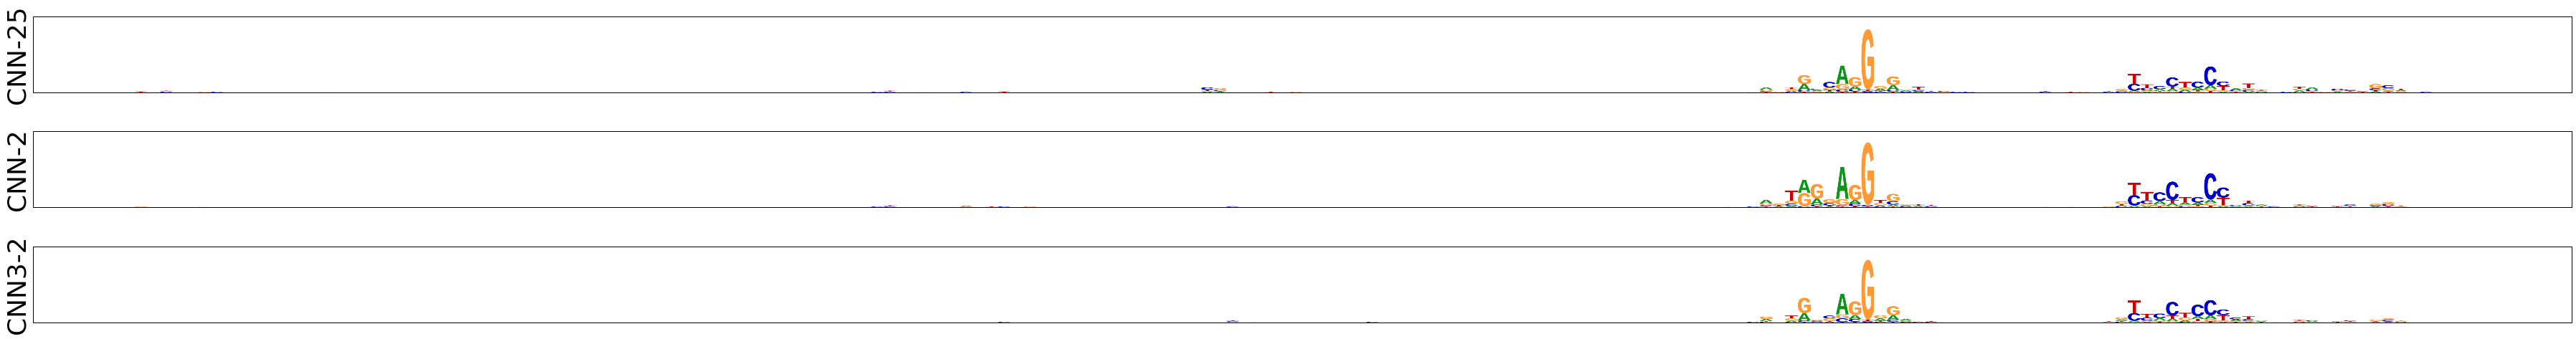

In [51]:

class_index = 8

# get indices of a sequence that has a positive label and has a single class label
right_indices = np.where((test['targets'][:,class_index]==1) & 
                               (class_sum == 1)
                              )[0]

# sort by most confident predictions
right_indices = right_indices[np.argsort(activations[right_indices, class_index])[::-1]][:num_plots]


right_index = right_indices[1]
# get the sequence and the sequence model
X = np.expand_dims(test['inputs'][right_index], axis=0)
X_model = test_model[right_index]


model_name = 'cnn_2'
genome_model = helper.import_model(model_name)
file_path = os.path.join(params_path, model_name)
params = {'model_name': model_name, 
          'genome_model': genome_model.model,
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
         }
guided_saliency = saliency.backprop(X, layer='output', class_index=class_index, params=params)


num_noise = 100
shape = list(X.shape)
shape[0] = num_noise
Z = np.random.normal(loc=0, scale=0.1, size=shape)
guided_saliency_smooth = saliency.backprop(np.tile(X,(num_noise,1,1,1))+Z, layer='output', class_index=class_index, params=params)
guided_saliency2 = np.mean(guided_saliency_smooth, axis=0)

guided_saliency3, counts = saliency.stochastic_backprop(X,layer='logits', class_index=class_index, params=params, num_average=100,include=10)


# sequence logo comparison between different CNN models
fig = plt.figure(figsize=(50,7))
plt.subplot(3,1,1)
visualize.plot_pos_saliency(np.squeeze(guided_saliency).T, alphabet='dna',height=150, nt_width=50, norm_factor=3)
plt.axis('on')
plt.xticks([])
plt.yticks([])
plt.ylabel('CNN-25', fontsize=36)
plt.subplot(3,1,2)
visualize.plot_pos_saliency(np.squeeze(guided_saliency2).T, alphabet='dna',height=150, nt_width=50, norm_factor=3)
plt.axis('on')
plt.xticks([])
plt.yticks([])
plt.ylabel('CNN-2', fontsize=36)
plt.subplot(3,1,3)
visualize.plot_pos_saliency(np.squeeze(guided_saliency3).T, alphabet='dna',height=150, nt_width=50, norm_factor=3)
plt.axis('on')
plt.xticks([])
plt.yticks([])
plt.ylabel('CNN3-2', fontsize=36)

In [43]:
counts

array([[1.]], dtype=float32)